<a href="https://colab.research.google.com/github/FabioPereira445/EBAC_Analista_de_Dados/blob/main/Analista_M16_projeto_analise_exploratoria_empresa_loggi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II


---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

**Empresa:** Loggi

A Loggi é uma startup unicórnio brasileira de tecnologia focada em logística. Ela começou entregando apenas documentos entre 2013 e 2014. Dois anos depois, entrou no segmento de e-commerce. E, desde 2017, tem atuado nas entregas de alimentos também.

**Desafio:**

Empresas de logística enfrentam desafios diários como otimizar rotas de entrega e alocar pedidos em frotas com capacidade limitada.

**Dados para Explorar Solução:**

Loggi BUD O Loggi Benchmark for Urban Deliveries (BUD) é um repositório do GitHub com dados e códigos para problemas típicos que empresas de logística enfrentam, como otimização das rotas de entrega, alocação de entregas nos veículos da frota com capacidade limitada etc.

**Destaques:**

Dados autênticos: Coletados de fontes públicas confiáveis (IBGE, IPEA) e refletem os desafios reais da Loggi em grande escala.
Foco em Brasília: Exploraremos as nuances da logística na capital federal.
Objetivo: Desvendar os segredos de eficiência na logística urbana e construir um futuro cada vez mais promissor e resiliente para o setor.

**Benefícios:**

Campo de testes ideal para soluções inovadoras em logística.
Abertura de caminho para soluções personalizadas e eficientes em Brasília.
Transformar desafios em oportunidades para o crescimento da Loggi.

**Próximos Passos:**

Mergulhar nos dados do BUD para entender os desafios logísticos de Brasília.
Desenvolver soluções inovadoras para otimizar rotas de entrega e alocar pedidos.
Colaborar com a Loggi para construir um futuro mais eficiente para a logística urbana.

## 2\. Pacotes e bibliotecas

In [1]:
# importando   bibliotecas necessárias e pacotes , seguindo  padrões do PEP8:


!pip3 install geopandas;

import json
import matplotlib.pyplot as plt
import numpy as np
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import pandas as pd
import seaborn as sns
import geopandas


In [2]:
#Donwload dos dados fornecidos  em Json
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

#Donwload  de dados com informação cidade e bairro dos delivery
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

##Donwload Mapa do Distrito Federal
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

## 3\. Exploração de dados

In [4]:
#código para exploração de dados:
#Carregando arquivo json em dicionario Python
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

#Criando DataFrame O dicionário é convertido em um DataFrame usando o pandas.
deliveries_df = pd.DataFrame(data)

# Criação de uma nova coluna com dados da origem:coluna  Origin normalizada  para possibilitar criar  uma nova coluna com apenas dados de interesse.
hub_origin_df = pd.json_normalize(deliveries_df["origin"])

#Juntando nova coluna ao dado principal
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]

#Renomeando Novas Colunas
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

#Normalização da coluna deliveries:
#A coluna deliveries é "explodida" para separar cada entrega em linhas individuais.
#Novas colunas são criadas com o tamanho da entrega (delivery_size), a longitude da entrega (delivery_lng) e a latitude da entrega (delivery_lat).
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

#Junção das novas colunas ao DataFrame principal resultando em um conjunto de dados completo com informações sobre as entregas, a origem e o destino.:
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head(20)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055
5,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,10,-48.120448,-15.847780
6,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.121802,-15.852089
7,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,10,-48.116300,-15.851215
8,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116317,-15.849660
9,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,8,-48.123115,-15.849925


In [5]:
#Estrutura dos dados:A forma do DataFrame é verificada para identificar o número de linhas e colunas.
deliveries_df.shape

(636149, 8)

In [6]:
#Verificação de dados faltantes:A função utilizada para verificar se há valores faltantes em cada coluna do DataFrame.
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

In [7]:
#Análise de atributos categóricos:As colunas categóricas do DataFrame são descritas usando a função describe() do pandas,
# fornecendo informações como o número de registros únicos, a frequência de cada valor e medidas estatísticas básicas.
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


## 4\. Manipulação

In [8]:
# código para  manipulação de dados:
#Geocodificação reversa dos hubs:
#A geocodificação reversa é aplicada às coordenadas dos hubs (centros de distribuição) para obter o endereço completo (cidade e bairro) de cada um.
#A biblioteca geopy é utilizada para realizar a geocodificação, com um limitador de taxa para evitar sobrecarga do serviço.
#As informações de cidade e bairro obtidas na geocodificação são armazenadas em novas colunas no DataFrame dos hubs.
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)

geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

#Aplicando geocodificação nas 3 regiões
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))

#Informação de cidade e bairro do hub
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)

#Combinação dos dados de hubs com o DataFrame principal:
#As informações de cidade e bairro dos hubs são unidas ao DataFrame principal, permitindo a análise conjunta das entregas e dos locais de origem e destino.
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()



,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


In [9]:
#Carregando arquivo CSV em DataFrame
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [10]:
#Combinando com DataFrame Principal
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [11]:
#o info traz uma visão global do dataframe, do que é composto permitindo  indentificar se tem algum vácuo com valor nulo
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [12]:
# código permite Consultar dados faltantes e tipo
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [13]:
#Criação de Mapa de Brasilia
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [14]:
#Criando DataFrame geo_hub_df com nova coluna geometry
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [15]:
#Criando DataFrame geo_deliveries_df com nova coluna geometry
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


## 5\. Visualização

<ipython-input-16-4edec934a4fa>:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


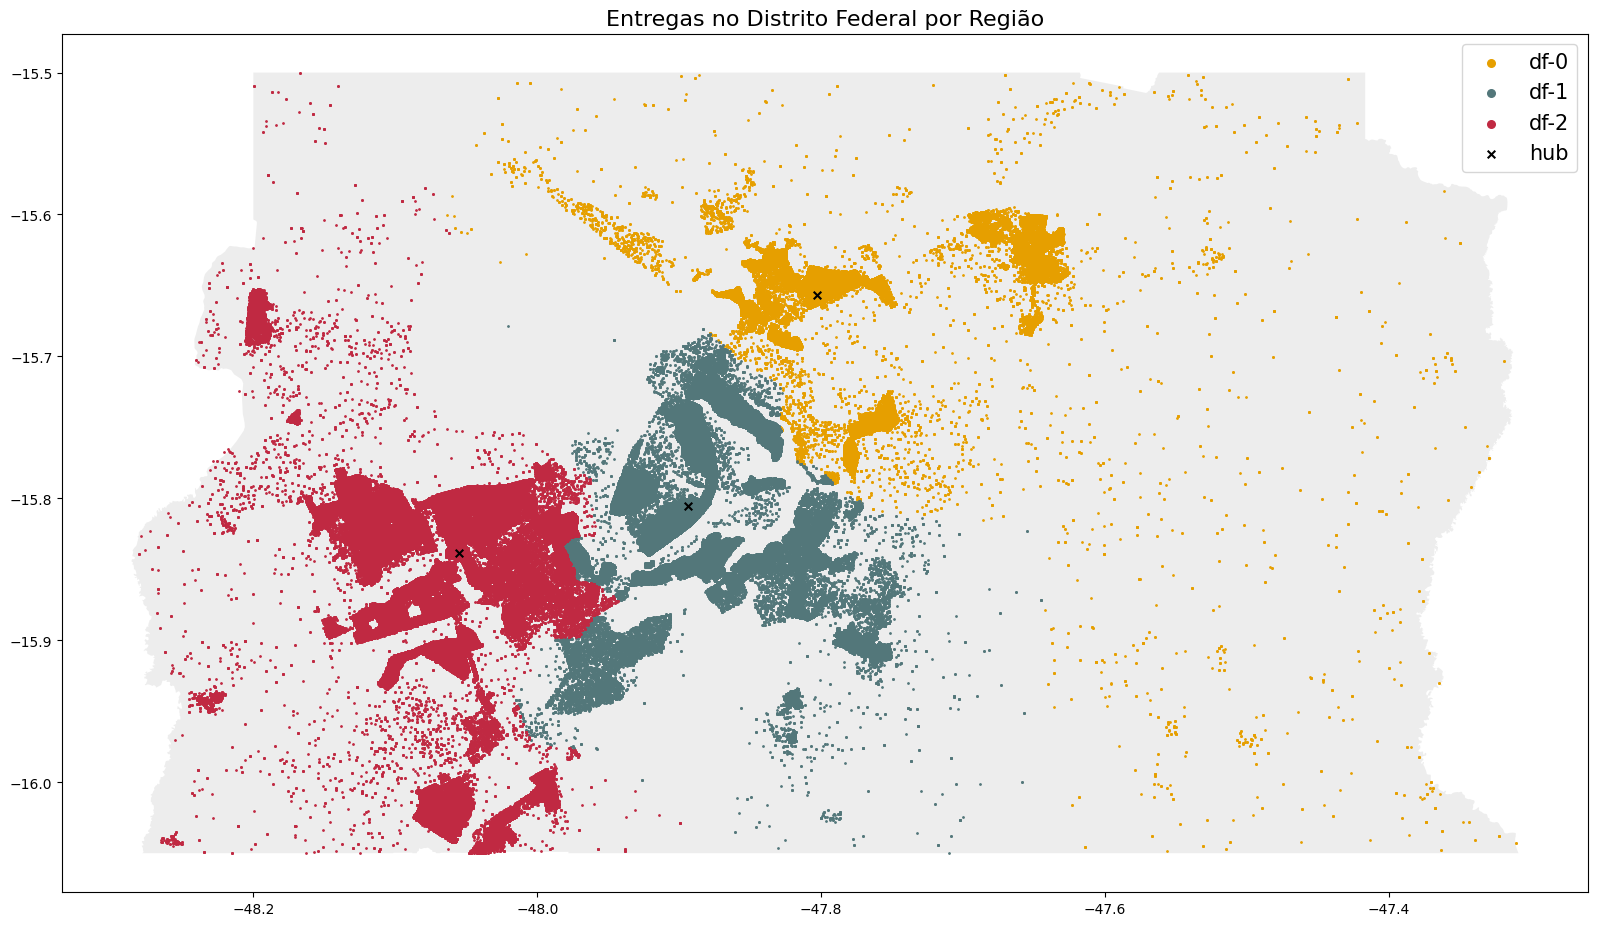

In [16]:
#  código para visualização de dados:

##Criando o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# Plot do mapa do Distrito Federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# Plot dos deliveries
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="#e69f00", label="df-0")  # Orange
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="#53777a", label="df-1")  # Blue-gray
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="#c02942", label="df-2")  # Red-pink

# Plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# Plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
  handle.set_sizes([30])


<ipython-input-22-9babb266c53c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=deliveries_count.index, y=deliveries_count.values, palette=palette)


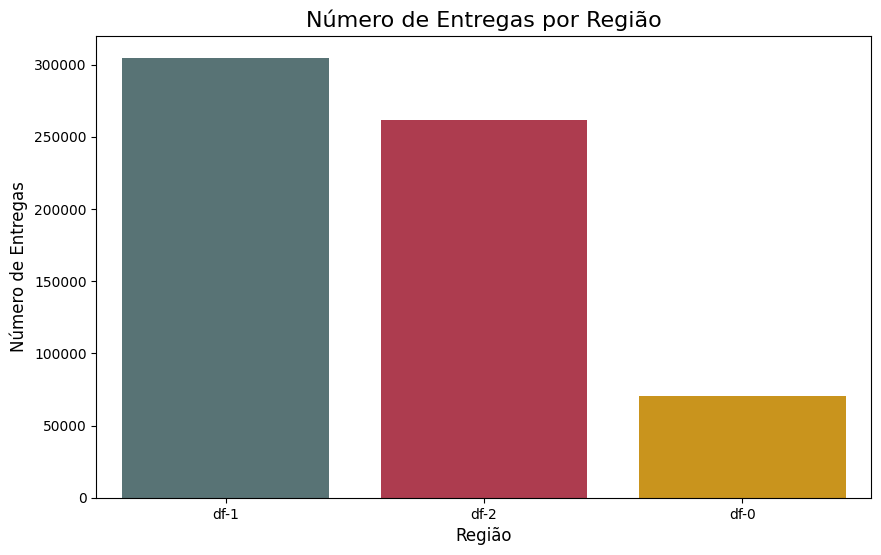

In [22]:

# Contar o número de entregas por região
deliveries_count = deliveries_df['region'].value_counts()

# Definir as cores para cada região
colors = {
    'df-0': '#e69f00',  # Orange
    'df-1': '#53777a',  # Blue-gray
    'df-2': '#c02942'   # Red-pink
}

# Criar uma lista de cores na ordem das regiões
palette = [colors[region] for region in deliveries_count.index]

# Criar um gráfico de barras para o número de entregas por região
plt.figure(figsize=(10, 6))
sns.barplot(x=deliveries_count.index, y=deliveries_count.values, palette=palette)

# Definir o título e os rótulos
plt.title('Número de Entregas por Região', fontsize=16)
plt.xlabel('Região', fontsize=12)
plt.ylabel('Número de Entregas', fontsize=12)

# Mostrar o gráfico
plt.show()


## Identificando nas regiões áreas com maior demanda de entrega por cidade:

<ipython-input-19-2cc98c0d5200>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='delivery_city', data=deliveries_df, order=deliveries_df['delivery_city'].value_counts().index, palette='viridis')


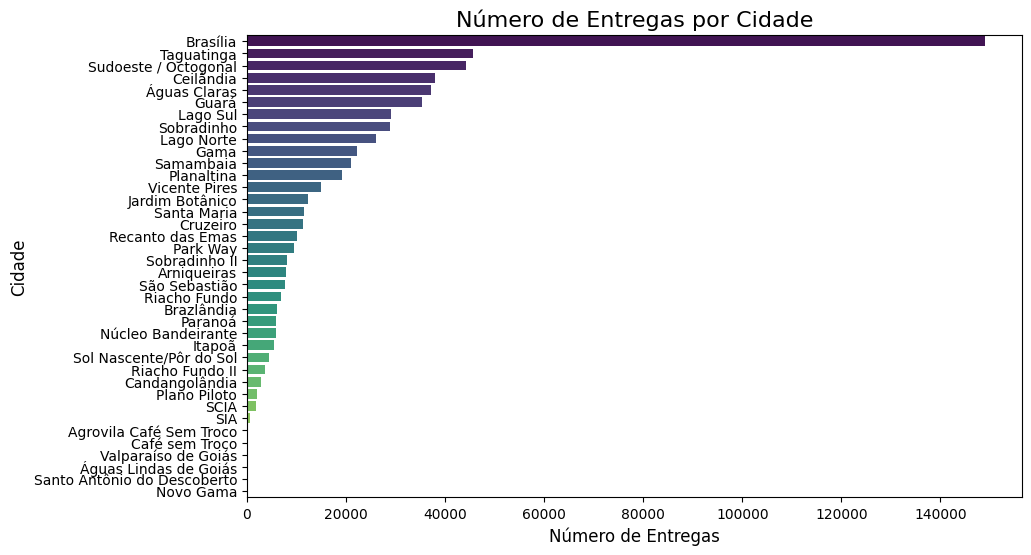

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(y='delivery_city', data=deliveries_df, order=deliveries_df['delivery_city'].value_counts().index, palette='viridis')
plt.title('Número de Entregas por Cidade', fontsize=16)
plt.xlabel('Número de Entregas', fontsize=12)
plt.ylabel('Cidade', fontsize=12)
plt.show()


# Capacidade dos Veículos vs. Quantidade de  Entregas:

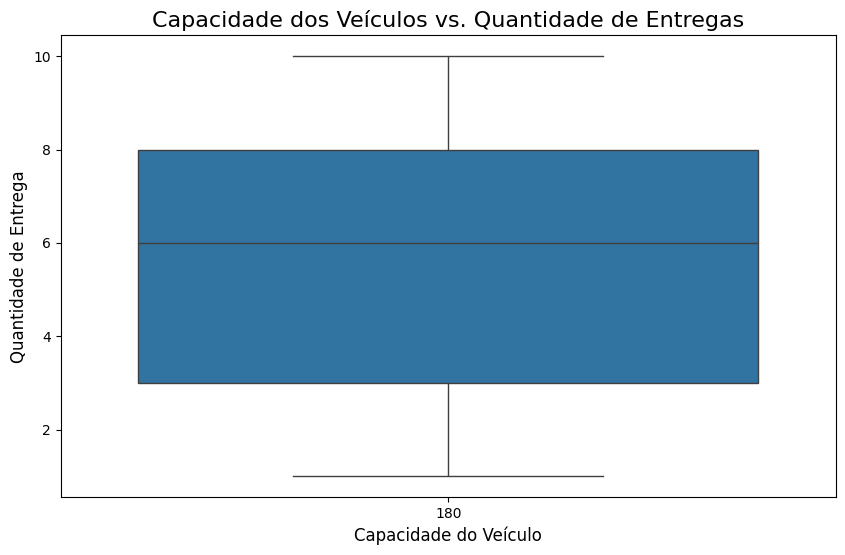

In [30]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='vehicle_capacity', y='delivery_size', data=deliveries_df)
plt.title('Capacidade dos Veículos vs. Quantidade de Entregas', fontsize=16)
plt.xlabel('Capacidade do Veículo', fontsize=12)
plt.ylabel('Quantidade de Entrega', fontsize=12)
plt.show()


# Ranking de Cidades/ Bairros com maior número de entregas por Região:

<ipython-input-28-45d43dc27301>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='delivery_suburb', data=top_20_region_data, ax=ax, palette='viridis')
<ipython-input-28-45d43dc27301>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='delivery_suburb', data=top_20_region_data, ax=ax, palette='viridis')
<ipython-input-28-45d43dc27301>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='delivery_suburb', data=top_20_region_data, ax=ax, palette='viridis')


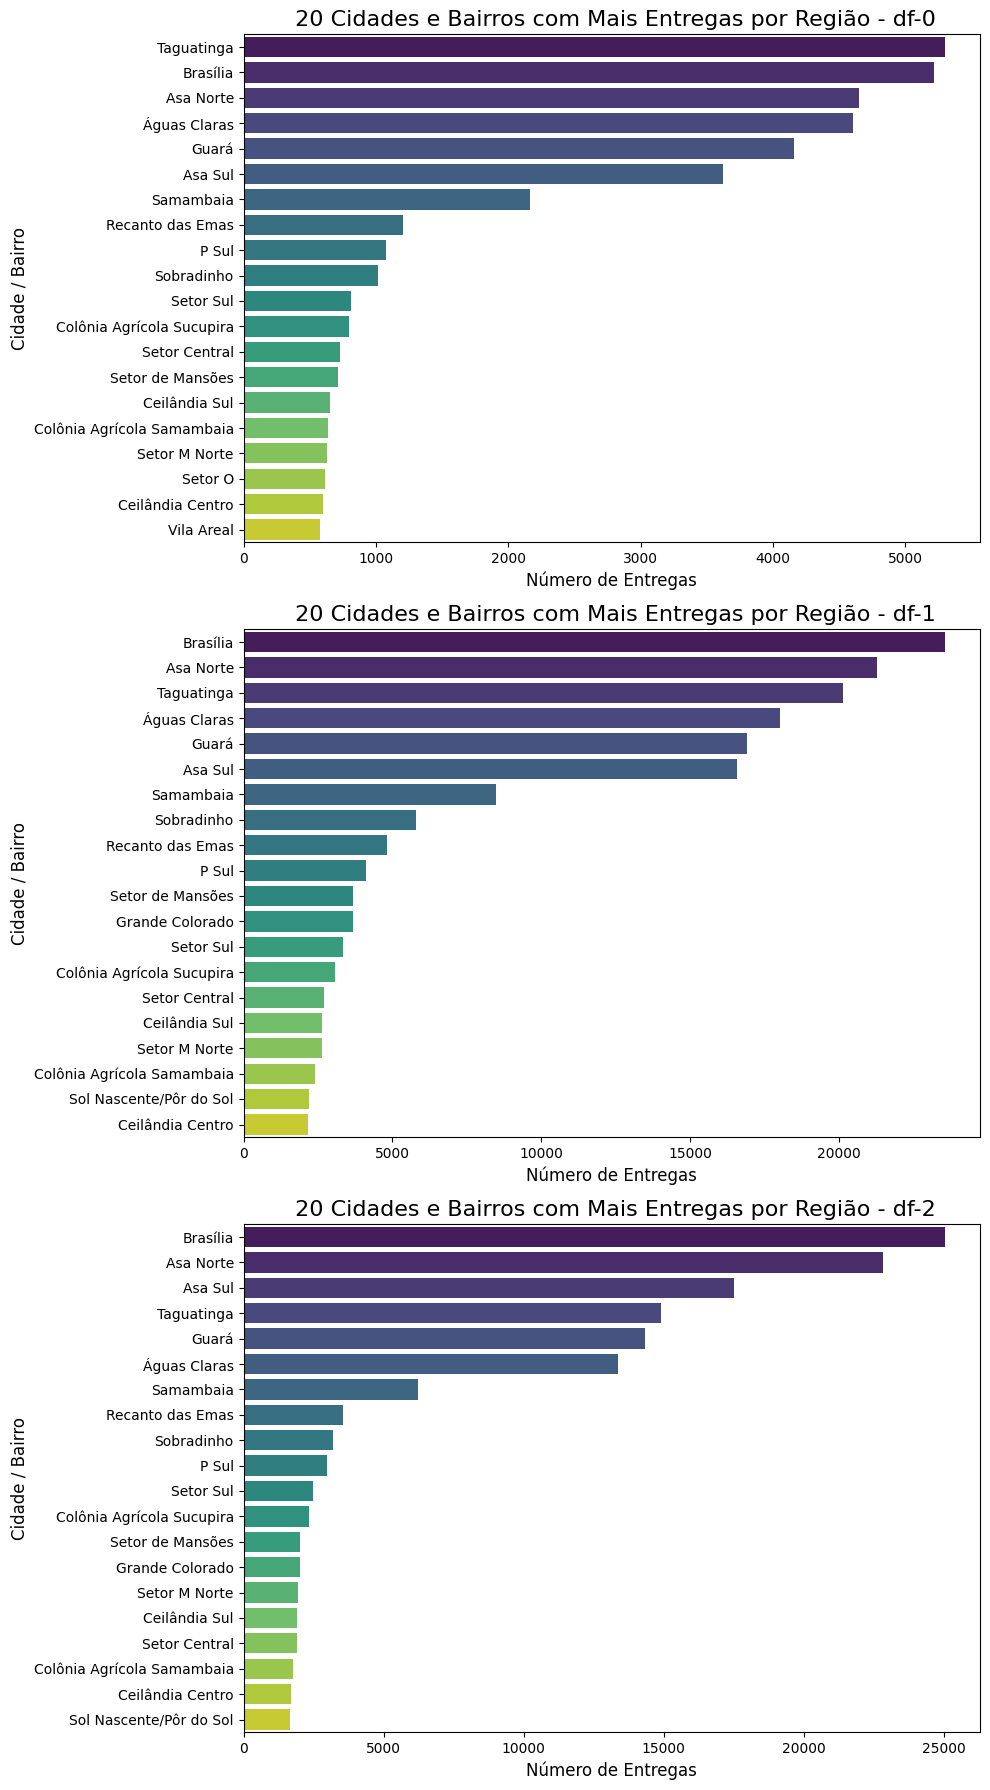

In [28]:


# Primeiro, precisamos agrupar os dados por região, cidade e bairro e contar as entregas
delivery_counts = deliveries_df.groupby(['region', 'delivery_city', 'delivery_suburb']).size().reset_index(name='count')

# Agora, vamos criar gráficos separados para cada região
regions = delivery_counts['region'].unique()

# Configurar a figura do matplotlib
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(10, 6 * len(regions)))

# Se houver apenas uma região, 'axes' não será um array, então fazemos isso para consistência
if len(regions) == 1:
    axes = [axes]

# Plotar os dados de cada região em um subplot separado
for ax, region in zip(axes, regions):
    # Filtrar o DataFrame para a região atual e ordenar pelo número de entregas
    region_data = delivery_counts[delivery_counts['region'] == region].sort_values(by='count', ascending=False)

    # Selecionar as top 20 cidades e bairros com mais entregas
    top_20_region_data = region_data.head(20)

    # Criar um gráfico de barras para a região atual
    sns.barplot(x='count', y='delivery_suburb', data=top_20_region_data, ax=ax, palette='viridis')

    # Definir o título para a região atual
    ax.set_title(f' 20 Cidades e Bairros com Mais Entregas por Região - {region}', fontsize=16)

    # Definir os rótulos dos eixos x e y
    ax.set_xlabel('Número de Entregas', fontsize=12)
    ax.set_ylabel('Cidade / Bairro', fontsize=12)

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()


# Resumo dos insights gerados:



#### Contexto do Projeto:
O projeto de análise exploratória de dados foi realizado para a empresa Loggi, uma startup brasileira de logística. O objetivo foi entender e otimizar os desafios logísticos enfrentados pela empresa, como a otimização de rotas de entrega e a alocação de pedidos em veículos com capacidade limitada.

#### Principais Insights Extraídos

1. **Identificação de Áreas de Alta Demanda:**
   - **Regiões df-0, df-1 e df-2**: Cidades como Brasília, Taguatinga, Asa Norte, e Águas Claras têm o maior número de entregas.
   - **Ação**: Focar em otimizar as operações nessas áreas de alta demanda, alocando mais recursos, como veículos e pessoal, para garantir entregas mais rápidas e eficientes.

2. **Planejamento de Recursos:**
   - **Insight**: A diferença no número de entregas entre as cidades e bairros sugere que a alocação de recursos pode ser ajustada para melhor atender à demanda.
   - **Ação**: Redistribuir a frota de veículos e a alocação de motoristas com base na demanda específica de cada cidade e bairro. Isso ajudará a evitar a subutilização ou sobrecarga de recursos em determinadas áreas.

3. **Oportunidades de Expansão:**
   - **Insight**: Cidades e bairros com um número significativo de entregas, mas que não estão no topo da lista, podem representar oportunidades de crescimento.
   - **Ação**: Investigar essas áreas para entender melhor as necessidades dos clientes e considerar a expansão dos serviços ou a abertura de novos hubs para atender melhor essas áreas.

4. **Eficiência Operacional:**
   - **Insight**: Analisar a eficiência das entregas nas áreas de maior demanda pode revelar oportunidades de melhoria.
   - **Ação**: Implementar tecnologias de otimização de rotas e monitoramento em tempo real para melhorar a eficiência das entregas. Isso pode incluir o uso de algoritmos de roteamento e sistemas de gestão de transporte (TMS).

5. **Utilização da Capacidade dos Veículos:**
   - **Insight**: A análise da capacidade dos veículos em relação ao tamanho das entregas mostrou que há uma correlação positiva, indicando uma utilização eficiente dos veículos.
   - **Ação**: Continuar monitorando a utilização dos veículos para garantir que eles estejam sendo usados de maneira eficiente. Ajustar a alocação de pedidos para maximizar a capacidade dos veículos pode ajudar a reduzir custos operacionais.

6. **Satisfação do Cliente:**
   - **Insight**: Áreas com alta demanda de entregas são críticas para a satisfação do cliente.
   - **Ação**: Garantir que as entregas nessas áreas sejam rápidas e confiáveis. Implementar sistemas de feedback do cliente para monitorar a satisfação e resolver problemas rapidamente.

### Conclusão:
Os insights extraídos deste projeto fornecem uma base sólida para otimizar as operações logísticas da Loggi. Ao focar em áreas de alta demanda, ajustar a alocação de recursos, explorar oportunidades de expansão e melhorar a eficiência operacional, a empresa pode aumentar sua eficiência e satisfação do cliente, resultando em um aumento no faturamento.
